Plot the log-probability and accuracy during training. 

In [1]:
import os
import json
import h5py
import numpy as np
import torch as t
import matplotlib.pyplot as plt
import pickle
import gc
import pandas as pd

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [2]:
number = 1.96

def get_center_and_ci(all_metrics, label, val_or_test, used_metric):
    center = []
    ci = []
    for entry in all_metrics[label][val_or_test][used_metric]:
        center.append(np.mean(entry))
        ci.append(number * np.std(entry))
    return np.array(center), np.array(ci)

In [3]:
def get_plots(run_dirs, labels, csv_path, lp_ylim, acc_ylim, fig_name, horizontal=False):
    split = True
    compare_time = False
    train_and_val = False

    average_runs = True
    trials = 10
    classification = True
    num_epochs = 400
    burnin = 1000

    if average_runs:
        sub_dirs = [str(i+1) for i in range(trials)]
    try:
        del all_metrics
    except:
        pass
    gc.collect()

    all_metrics = dict()
    all_timestamps = dict()

    data_types = ["val", "test"]
    used_metrics = ["lp_ensemble", "acc_ensemble"]
    indexes = [i for i in range(num_epochs)]

    if average_runs:
        for (run_dir, label) in zip(run_dirs, labels):
            all_metrics[label] = dict()
            for data_type in data_types:
                all_metrics[label][data_type] = dict()
                for used_metric in used_metrics:
                    all_metrics[label][data_type][used_metric] = [[] for _ in range(num_epochs)]
            for sub_dir in sub_dirs:
                with open(f'{run_dir}/{sub_dir}/evaluations.pkl', 'rb') as f:
                    evaluations = pickle.load(f)
                    for data_type in data_types:
                        for (index, entry) in enumerate(evaluations[data_type]):
                            for used_metric in used_metrics:
                                all_metrics[label][data_type][used_metric][index].append(entry[used_metric])                    
    else:
        for (run_dir, label) in zip(run_dirs, labels):
            all_metrics[label] = dict()
            with open(f'{run_dir}/evaluations.pkl', 'rb') as f:
                evaluations = pickle.load(f)
                for data_type in data_types:
                    for (index, entry) in enumerate(evaluations[data_type]):
                            for used_metric in used_metrics:
                                all_metrics[label][data_type][used_metric][index] = entry[used_metric]

    colors = {'VanillaSGLD': 'b', 'WenzelSGLD': 'k', 'pSGLD': 'r', 'MongeSGLD': 'c', 'ShampooSGLD': 'g'}
    metric_names = {'VanillaSGLD': 'Identity', 'WenzelSGLD': 'Wenzel', 'pSGLD': 'RMSprop', 'MongeSGLD': 'Monge', 'ShampooSGLD': 'Shampoo'}

    if horizontal:
        plt.figure(figsize=(20, 6), dpi=300)
        plt.rcParams.update({"font.size": 20})
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)
        plt.subplots_adjust(wspace=0.25)
    else:
        plt.figure(figsize=(10, 10), dpi=300)
        plt.rcParams.update({"font.size": 20})
        ax1 = plt.subplot(211)
        ax2 = plt.subplot(212)
        plt.subplots_adjust(hspace=0.3)
    
    plt.rcParams["text.usetex"] = True

    for used_metric in used_metrics:

        if used_metric == 'lp_ensemble':
            name = "log probability"
            for label in labels:
                center, ci = get_center_and_ci(all_metrics, label, "test", used_metric)
                ax1.plot(indexes, center, label=metric_names[label], color=colors[label], linewidth=2.5)
                ax1.fill_between(indexes, center-ci, center+ci, color=colors[label], alpha=0.1)
            ax1.set_ylim(lp_ylim[0], lp_ylim[1])
            ax1.set_xlabel("epochs")
            ax1.set_ylabel("log-probability")
        elif used_metric == 'acc_ensemble':
            name = "accuracy"
            for label in labels:
                center, ci = get_center_and_ci(all_metrics, label, "test", used_metric)
                ax2.plot(indexes, center, label=metric_names[label], color=colors[label], linewidth=2.5)
                ax2.fill_between(indexes, center-ci, center+ci, color=colors[label], alpha=0.1)
            ax2.set_ylim(acc_ylim[0], acc_ylim[1])
            ax2.set_xlabel("epochs")
            ax2.set_ylabel("accuracy")
            plt.legend(loc="lower right", prop={"size": 15})
            if horizontal:
                plt.savefig(f'figs/convergence_{fig_name}_h.png', bbox_inches="tight")
            else:
                plt.savefig(f'figs/convergence_{fig_name}.png', bbox_inches="tight")
        else:
            raise Exception


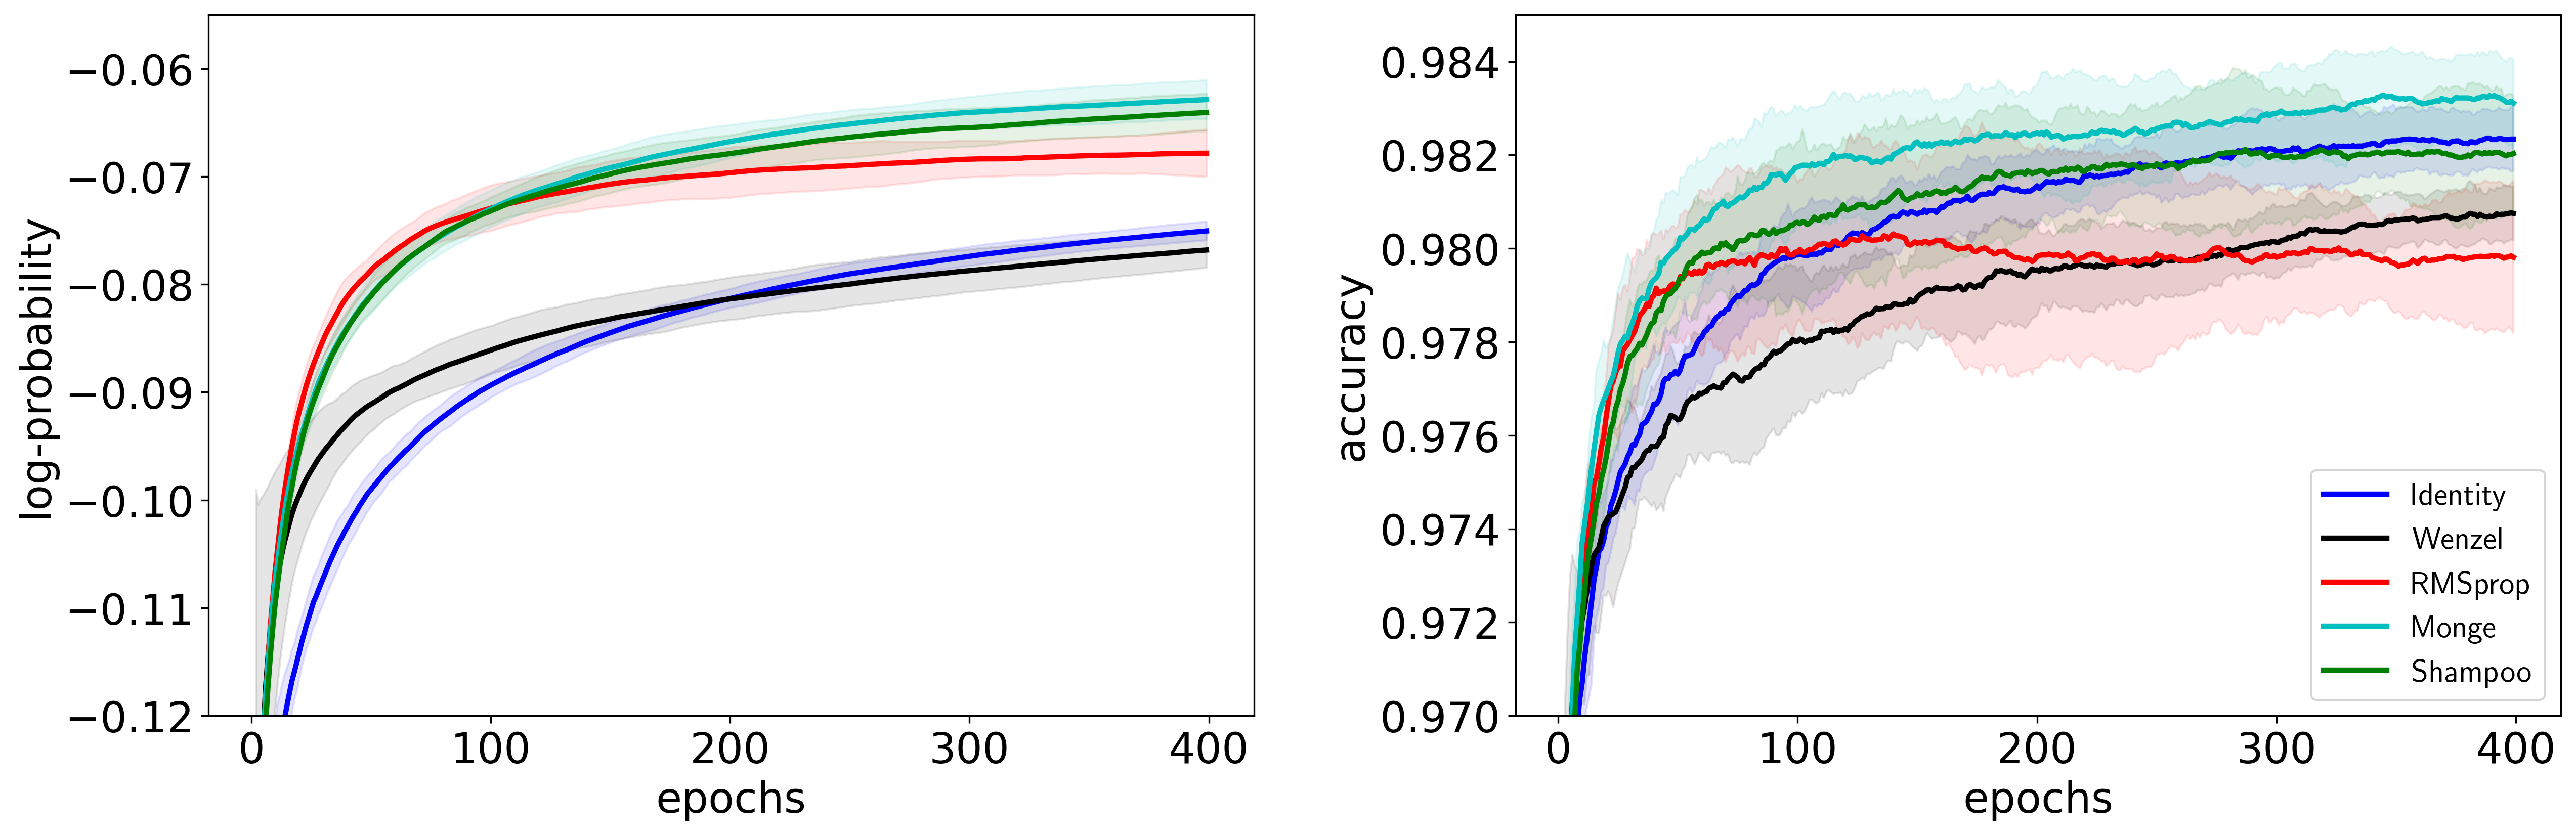

In [4]:
run_dirs = ['../results/mnist_400_horseshoe_1.0_100_flat_400_1000_evaluations/VanillaSGLD_0.25', '../results/mnist_400_horseshoe_1.0_100_flat_400_1000_evaluations/WenzelSGLD_0.75', '../results/mnist_400_horseshoe_1.0_100_flat_400_1000_evaluations/pSGLD_0.0005', '../results/mnist_400_horseshoe_1.0_100_flat_400_1000_evaluations/MongeSGLD_0.25_monge_alpha_2=1.25', '../results/mnist_400_horseshoe_1.0_100_flat_400_1000_evaluations/ShampooSGLD_0.005']
labels = ['VanillaSGLD', 'WenzelSGLD', 'pSGLD', 'MongeSGLD', 'ShampooSGLD']
csv_path = "csvs/mnist_400_horseshoe_1.0_100_flat_400_1000_evaluations.csv"
lp_ylim = [-0.12, -0.055]
acc_ylim = [0.97, 0.985]
fig_name = "400"

get_plots(run_dirs, labels, csv_path, lp_ylim, acc_ylim, fig_name, horizontal=True)
